## Wykład 4 - Jak działa GPT
Prosta sieć neuronowa z biblioteką PyTorch (torch.nn)

* Zaimplementujemy to samo, co na laboratorium 1, ale z wykorzystaniem modułu **torch.nn**
* Następnie omówimy warstwę **torch.nn.Embedding**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

##### Dane uczące
* generujemy dane (X) - 300 przykładów o dwóch cechach
* oraz prawidłowe etykiety y - dla trzech klas

##### Klasyfikacja
Zadaniem algorytmu jest klasyfikacja kropek do trzech kategorii (0 - żółty, 1 - zielony, 2 - czerwony)

In [2]:
def generate_data(n_samples=300):
    X = torch.rand(n_samples, 2) * 10 - 5 
    
    y = torch.zeros(n_samples, dtype=torch.long)
    y[X[:, 1] > 2 * X[:, 0] + 4] = 0  # Klasa 0
    y[X[:, 1] < 2 * X[:, 0] - 4] = 1  # Klasa 1
    y[(X[:, 1] <= 2 * X[:, 0] + 4) & (X[:, 1] >= 2 * X[:, 0] - 4)] = 2  # Klasa 2
    
    return X, y

In [3]:
X, y = generate_data()

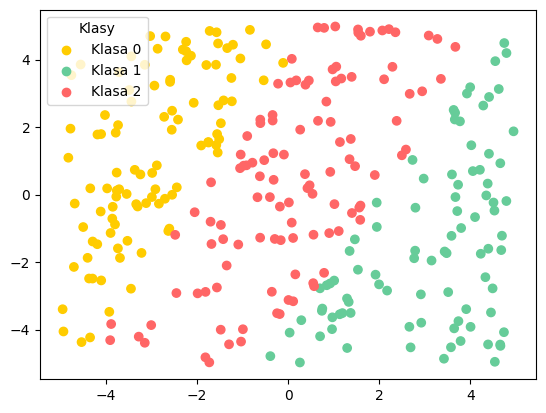

In [4]:
colors = ['#FFCC00', '#66CC99', '#FF6666']
cmap = ListedColormap(colors[:len(torch.unique(y))])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);
classes = np.unique(y)
for cls in classes:
    plt.scatter([], [], color=cmap(cls), label=f'Klasa {cls}')

plt.legend(title="Klasy");

#### Torch nn.Module
* Sieci neuronowe wygodnie jest budować dziedzicząc z klasy nn.Module
* Każdy model powinien implementować metodę **forward**, która przyjuje jako argument dane wejściowe i zwraca wyjście sieci
* Warstwa **nn.Linear** implementuje jedną warstwę MLP bez funkcji aktywacji
  $$ XW^T + b$$
(transpozycja ze względu na kształty macierzy, wydruk kształtów poniżej)
* Moduł **torch.nn.functional.F** zawiera przydatne funkcje np. softmax

In [5]:
class MulticlassClassifier(nn.Module):
    def __init__(self):
        super(MulticlassClassifier, self).__init__() # wywołujemy konstruktor z klasy bazowej
        self.linear = nn.Linear(2, 3)  # 2 cechy wejściowe, 3 klasy
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [6]:
model = MulticlassClassifier()

In [7]:
for name, param in model.named_parameters():
    print(name)
    print(param.shape)

linear.weight
torch.Size([3, 2])
linear.bias
torch.Size([3])


In [8]:
# przenosimy dane i model na gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y = X.to(device), y.to(device)
model = MulticlassClassifier().to(device)

In [9]:
device

device(type='cuda')

In [10]:
# korzystamy z gotowego algorytmu optymalizacji z modułu torch.optim
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

#### Pętla uczenia
* Zerujemy gradienty (optimizer.zero_grad())
* Wyznaczamy logity (uwaga: logity, a nie prawdopodobieństwa)
* Liczymy wartość funkcji straty wykorzystując **F.cross_entropy** (uwaga: ze względów numerycznych funkcja na wejściu przyjmuje **logity**
* Nie musimy również przekształcać y na kodowanie one-hot **F.cross_entropy** zrobi to wewnętrznie, a jako argument przyjmuje **indeksy** prawidłowej klasy
* Wyznaczamy gradienty (loss.backward())
* Wykonujemy krok optymalizacji (optimizer.step())

In [52]:
for epoch in range(1000):
    optimizer.zero_grad()
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.1720
Epoch 100: Loss = 0.1659
Epoch 200: Loss = 0.1606
Epoch 300: Loss = 0.1558
Epoch 400: Loss = 0.1516
Epoch 500: Loss = 0.1477
Epoch 600: Loss = 0.1443
Epoch 700: Loss = 0.1411
Epoch 800: Loss = 0.1381
Epoch 900: Loss = 0.1354


In [53]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100),
                            torch.linspace(y_min, y_max, 100))
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    logits = model(grid.to(device))
    preds = torch.argmax(logits, dim=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, preds.cpu().numpy(), alpha=0.3, cmap=cmap)
    plt.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), c=y.cpu().numpy(), cmap=cmap)
    plt.title("Granice decyzyjne")
    plt.show()

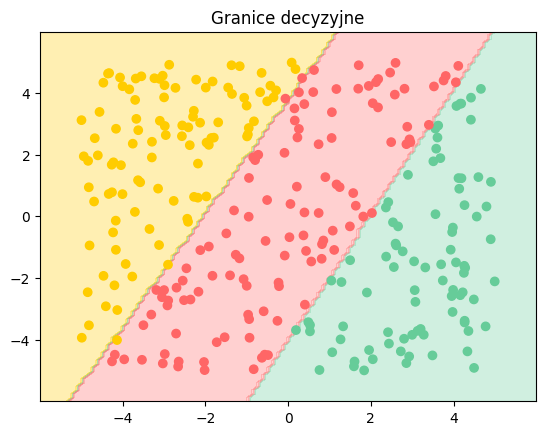

In [54]:
plot_decision_boundary(model, X, y);

### Warstwa Embedding

Linear:
* W warstwie Linear wykonujemy przekształcenie $ XW^T + b$
* Dane wejściowe $X$ to dane ciągłe (float)

Embedding:
* Stosowana dla dyskretnych danych wejściowych $X$ (np. indeksy tokenów)
* Wykorzystuje macierz wag $W$, nie wykorzystuje $b$
* Warstwa ta wybiera reprezentację wektorową dla odpowiedniego indeksu (np. wektor odpowiadający danemu tokenowi)
* Dokładnie taką macierz uczyliśmy na laboratorium 2

In [55]:
# 100 indeksów, wymiar wektora 5
embedding = nn.Embedding(num_embeddings=100, embedding_dim=5)

In [58]:
for name, param in embedding.named_parameters():
    print(name)
    print(param.shape)

weight
torch.Size([100, 5])


In [60]:
embedding.weight.shape

torch.Size([100, 5])

In [69]:
embedding.weight[:5]

tensor([[ 0.6121,  1.2443, -0.4414, -1.3150, -0.4533],
        [ 0.1640, -2.7287,  1.7279,  0.1973,  0.6926],
        [-2.0048,  0.2458, -2.0639, -0.5500,  0.6907],
        [ 0.6329,  0.0178,  0.8187,  0.8686,  0.5244],
        [-1.8306, -0.9821, -0.3847,  0.3337, -0.6226]],
       grad_fn=<SliceBackward0>)

In [71]:
x = torch.tensor([[1], [4]]) # rozmiar batcha 2, każdy przykład to 1 token
x

tensor([[1],
        [4]])

In [72]:
output = embedding(x)
output.shape

torch.Size([2, 1, 5])

In [73]:
# zamiana kształtu (środkowy wymiar to długość sekwencji, nie potrzebujemy go jeszcze)
output = output.view(2, 5)
output.shape

torch.Size([2, 5])

In [74]:
output

tensor([[ 0.1640, -2.7287,  1.7279,  0.1973,  0.6926],
        [-1.8306, -0.9821, -0.3847,  0.3337, -0.6226]],
       grad_fn=<ViewBackward0>)